In [12]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from itertools import combinations

Load deltas in a given healpix pixel delta-healpix.fits.gz

In [13]:
deltas_path='/global/cfs/cdirs/desi/science/lya/mock_analysis/develop/ifae-ql/qq_desi_y3/v1.0.5/analysis-0/jura-124/raw_bao_unblinding/deltas_lya/Delta/'
delta_file=deltas_path+'delta-500.fits.gz' # 500 is the healpix pixel 
file = fits.open(delta_file)
num_of_skewers = len(file)-1

Choose redshift bin in which you want to measure the power spectrum

In [14]:
z_bin = 2.2
dz = 0.4
z_start = z_bin - dz/2
z_end = z_bin + dz/2
lam_lya = 1215.67 #Angstrom  
lamobs_start = lam_lya*(1+z_start)
lamobs_end = lam_lya*(1+z_end)
print(lamobs_start,lamobs_end)
pw_A  = 0.8
lamarray = np.arange(lamobs_start,lamobs_end,pw_A)

3647.01 4133.278


For each skewer, extract the deltas in the redshift range of measurement

In [15]:
extracted_deltas = []
extracted_lamobs = []
extracted_coords = []
for i in range(int(num_of_skewers)):
    ihdu=i+1
    z_qso=file[ihdu].header['Z']
    lam_obs = 10.0**(file[ihdu].data['LOGLAM'])
    delta_data=file[ihdu].data['DELTA']
    if np.any(lam_obs <= lamobs_start) and np.any(lam_obs >= lamobs_end):
        # Extract only the valid range
        filtered_deltas = delta_data[(lam_obs >= lamobs_start) & (lam_obs <= lamobs_end)]
        extracted_deltas.append(filtered_deltas)
        filtered_lamobs = lam_obs[(lam_obs >= lamobs_start) & (lam_obs <= lamobs_end)]
        extracted_lamobs.append(filtered_lamobs)
        RA = file[ihdu].header['RA']
        DEC = file[ihdu].header['DEC']
        #print(RA,DEC)
        c = SkyCoord(ra=RA*u.rad, dec=DEC*u.rad, frame='icrs')
        extracted_coords.append(c)
        #print(filtered_lamobs)
        #print(ihdu)
        #plt.plot(lam_obs,delta_data)
        #plt.plot(filtered_lamobs,filtered_deltas)

extracted_deltas = np.array(extracted_deltas)   
extracted_lamobs = np.array(extracted_lamobs) 
print(np.shape(extracted_deltas))
print('number of sightlines in the given redshift bin:',len(extracted_deltas[:,0]))
N_skewers = len(extracted_deltas[:,0])

(82, 608)
number of sightlines in the given redshift bin: 82


Fourier transform of deltas 

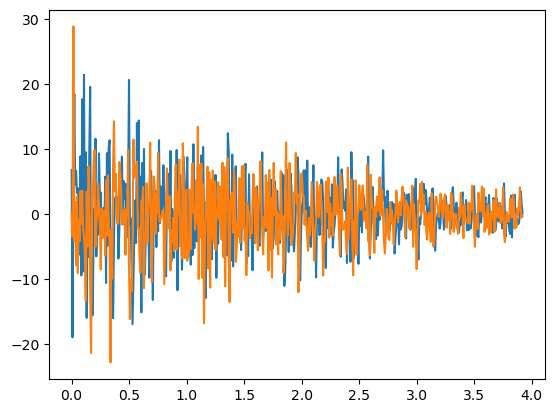

In [22]:
N_FFT  = 1024
k_arr = np.fft.fftfreq(N_FFT)*2*np.pi/pw_A
#print(k_arr[:N_FFT//2])
#print(len(extracted_deltas[0,:]))
delta_ft = np.zeros((len(extracted_deltas[:,0]),len(extracted_deltas[0,:])))
pad_ft  = np.zeros((len(extracted_deltas[:,0]),N_FFT),dtype=np.complex64)
padded_deltas = np.pad(extracted_deltas, pad_width=((0, 0), (0, N_FFT - len(extracted_deltas[0,:]))), mode='constant')

for l in range(len(extracted_deltas[:,0])):
    pad_ft[l,:] = np.fft.fft(padded_deltas[l,:])

plt.plot(k_arr[:N_FFT//2],pad_ft.real[0,:N_FFT//2])
plt.plot(k_arr[:N_FFT//2],pad_ft.imag[0,:N_FFT//2])

Angular seperation between pair of any two sightlines theta_ij

In [23]:
ihdu = 1
RA = file[ihdu].header['RA']
DEC = file[ihdu].header['DEC']
print(RA,DEC)
c = SkyCoord(ra=RA*u.rad, dec=DEC*u.rad, frame='icrs')
ihdu = 2
RA = file[ihdu].header['RA']
DEC = file[ihdu].header['DEC']
c2 = SkyCoord(ra=RA*u.rad, dec=DEC*u.rad, frame='icrs')
c.separation(c2).rad

2.01599816464593 0.751564366223673


0.001966053635268808

In [8]:
# Python function to measure angular separation 
#def angular_separation(ra1, dec1, ra2, dec2):
    # Calculate the difference in right ascension
#    delta_ra = ra2 - ra1
    
    # Apply the formula for angular separation
#    angular_distance = np.arccos(np.sin(dec1) * np.sin(dec2) +
#                                 np.cos(dec1) * np.cos(dec2) * np.cos(delta_ra))
    
#    return angular_distance
#angular_separation(c.ra.rad,c.dec.rad,c2.ra.rad,c2.dec.rad)      

In [71]:
# Generate all unique pairs
pairs = list(combinations(range(N_skewers), 2))
#print(N_skewers)
#print(len(pairs))
# Add self-pairs
self_pairs = [(i, i) for i in range(N_skewers)]
# Combine both
all_pairs = self_pairs + pairs 
#print(all_pairs)
separations = [extracted_coords[i].separation(extracted_coords[j]).rad for i, j in all_pairs] # in radians

In [72]:
theta_ij = np.column_stack((all_pairs, separations))

In [73]:
print(theta_ij[:,2])
print(theta_ij[:,2].min(),theta_ij[:,2].max())

[0.         0.         0.         ... 0.00630777 0.01937503 0.01331821]
0.0 0.08688097802208297


Bin the angular separations

In [74]:
num_bins = 500
theta_bins = np.linspace(theta_ij[:,2].min(),theta_ij[:,2].max()+0.1,num_bins)
dtheta = theta_bins[1]-theta_bins[0]
#print(dtheta,theta_bins[2]-theta_bins[1])
theta_values = theta_ij[:,2]
counts, bin_edges = np.histogram(theta_values, bins=theta_bins)

Text(0, 0.5, 'Number of Pairs')

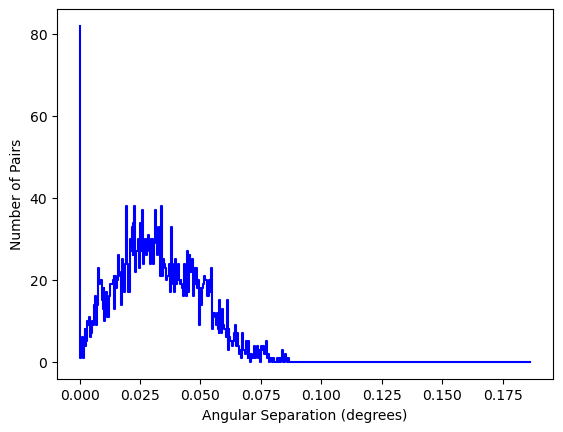

In [75]:
plt.step(bin_edges[:-1], counts, where='mid', color='b', lw=1.5)
plt.xlabel("Angular Separation (degrees)")
plt.ylabel("Number of Pairs")

Product of fourier deltas in a given angular separation bin

In [78]:
bin_indices = np.digitize(theta_values, theta_bins) - 1  # Convert to 0-based index
print(bin_indices)

[ 0  0  0 ... 16 51 35]


In [79]:
print(theta_bins[bin_indices[990]], "<=", theta_values[990], "<", theta_bins[bin_indices[990]+1])

0.03295696606401463 <= 0.03306280719657987 < 0.0333314770420148


In [93]:
# Create a dictionary to store pairs for each bin
binned_pairs = {i: [] for i in range(len(theta_bins) - 1)}
print(len(theta_bins))

# Loop over bin numbers and assign the corresponding pairs
for bin_num in range(len(theta_bins) - 1):
    mask = bin_indices == bin_num  # Find all pairs that belong to this bin
    binned_pairs[bin_num] = theta_ij[mask]  
    
# Convert lists to arrays for easier indexing
for key in binned_pairs:
    binned_pairs[key] = np.array(binned_pairs[key])

# Example: Print pairs in the 10th bin
print(f"Pairs in bin 10 (θ ∈ [{theta_bins[10]:.3f}, {theta_bins[11]:.3f}]):")
print(binned_pairs[10])

500
Pairs in bin 10 (θ ∈ [0.004, 0.004]):
[[2.00000000e+00 5.00000000e+01 3.79093163e-03]
 [1.10000000e+01 5.00000000e+01 4.04303684e-03]
 [2.30000000e+01 3.00000000e+01 3.90187399e-03]
 [2.70000000e+01 7.80000000e+01 4.09281241e-03]
 [4.20000000e+01 5.10000000e+01 4.08360052e-03]
 [4.20000000e+01 5.40000000e+01 3.75681955e-03]
 [5.90000000e+01 6.80000000e+01 4.08970526e-03]
 [6.00000000e+01 6.40000000e+01 3.82295235e-03]
 [7.50000000e+01 7.80000000e+01 3.88764732e-03]]


In [99]:
binned_products = {}

for bin_num, pairs in binned_pairs.items():
    i_indices = pairs[:, 0].astype(int)
    j_indices = pairs[:, 1].astype(int)

    # Compute pairwise products of pad_fts
    products = pad_ft[i_indices] * np.conj(pad_ft[j_indices])  # Cross power spectrum
    
    binned_products[bin_num] = products  

# Convert lists to arrays
for key in binned_products:
    #if binned_products[key]:  # Avoid empty bins
    binned_products[key] = np.array(binned_products[key])
    #else:
    #    binned_products[key] = np.zeros((0, pad_ft.shape[1]))  # Empty bin placeholder

print(np.shape(binned_products[50]))

# Example: Print the product for bin 10
print(f"Product of pad_ft for pairs in bin 10 (θ ∈ [{theta_bins[10]:.3f}, {theta_bins[11]:.3f}]):")
print(len(binned_products))

print(binned_products[0])
print(np.sum(binned_products[0],axis=0))

(17, 1024)
Product of pad_ft for pairs in bin 10 (θ ∈ [0.004, 0.004]):
499
[[ 46.45057 +0.0000000e+00j 369.3521  +1.8090923e-06j
  844.74677 -2.0670177e-06j ... 360.03473 -3.4558470e-06j
  844.74677 +2.0670177e-06j 369.3521  -1.8090923e-06j]
 [ 93.350586+0.0000000e+00j 741.68066 +1.1916796e-05j
  432.27362 -9.8400233e-07j ... 111.01091 -8.5467263e-08j
  432.27362 +9.8400233e-07j 741.68066 -1.1916796e-05j]
 [ 36.277653+0.0000000e+00j   7.934421+5.2927305e-08j
   68.977455-9.3566996e-08j ... 212.2084  +2.5587378e-06j
   68.977455+9.3566996e-08j   7.934421-5.2927305e-08j]
 ...
 [ 18.657198+0.0000000e+00j  73.42478 +7.3949877e-08j
   38.17491 -5.0040057e-07j ...  81.74636 -3.4854520e-07j
   38.17491 +5.0040057e-07j  73.42478 -7.3949877e-08j]
 [565.9092  +0.0000000e+00j 132.22926 -1.3183817e-06j
   93.87043 -5.4965994e-08j ...  33.455   +3.7877066e-07j
   93.87043 +5.4965994e-08j 132.22926 +1.3183817e-06j]
 [159.73552 +0.0000000e+00j  20.439806+4.6153907e-09j
   45.164562+2.8963768e-08j ...

In [100]:
Pcross = np.zeros((num_bins,N_FFT))
#print(binned_products[0][1,])
for ind in range(num_bins-1):
    Pcross[ind][:] = np.sum(binned_products[ind],axis=0).real   

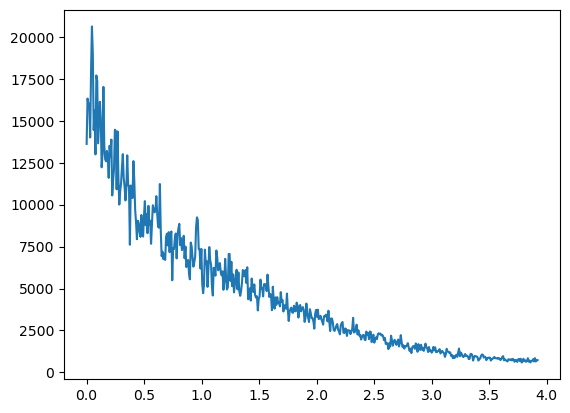

In [118]:
plt.plot(k_arr[:N_FFT//2],Pcross[0][:N_FFT//2])

In [102]:
p1d_km = pw_A/N_FFT*1/N_skewers*np.sum(np.abs(pad_ft)**2,axis=0) # Ignored the resolution function R_a(x)

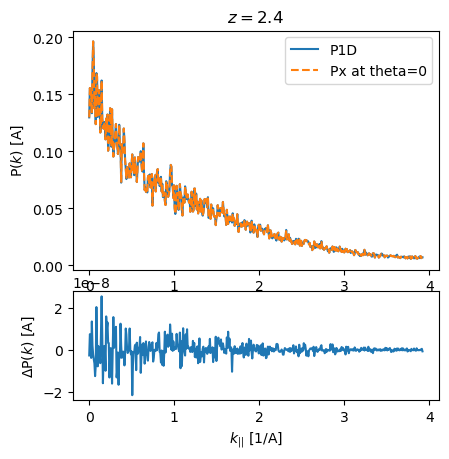

In [151]:
ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2) 
ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3,rowspan=2)
ax1.plot(k_arr[:N_FFT//2],p1d_km[:N_FFT//2],label='P1D')
ax1.plot(k_arr[:N_FFT//2],pw_A/N_FFT*1/N_skewers*Pcross[0][:N_FFT//2],label='Px at theta=0',linestyle='--')
ax2.plot(k_arr[:N_FFT//2],pw_A/N_FFT*1/N_skewers*Pcross[0][:N_FFT//2]-p1d_km[:N_FFT//2])
#plt.plot(k_arr[:N_FFT//2],Pcross[0][:N_FFT//2]/p1d_km[:N_FFT//2])
#print(Pcross[0][:N_FFT//2]/p1d_km[:N_FFT//2])
ax1.set_title('$z=2.4$')
ax2.set_xlabel('$k_{||}$ [1/A]')
ax1.set_ylabel('P($k$) [A]')
ax2.set_ylabel('$\Delta$P($k$) [A]')
#ax1.set_xlim(-0.1,1)
#ax2.set_xlim(-0.1,1)
ax1.legend()
plt.savefig('px_ml_vs_p1d_z2.4.png',dpi=400,bbox_inches='tight')